# Procesamiento

## Adaptación a torch-geometric-temporal

https://arxiv.org/abs/2110.06324

In [1]:
import torch
from torch.nn import functional as F
#from torch_geometric.utils import to_dense_adj, dense_to_sparse
import pandas as pd
#from torch_geometric.data import Data, Dataset
import os


In [2]:
import torch

print(pd.__version__)


1.3.5


In [3]:
from torch_geometric.data import Data, Dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import torch
import torch.nn.functional as F

sns.set_style("white")
sns.set_palette("coolwarm_r")

import torch
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [8]:
from torch_geometric_temporal.nn.recurrent import GCLSTM

from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from dataloader_pyg.dynamic_graph_temporal_signal import DynamicGraphTemporalSignalLen


In [9]:
class PowerGridDatasetLoader(object):
    def __init__(self, natural_folder):
        self._natural_folder = natural_folder
        self.voltages = {}
        self.edge_attr = []
        self.edge_index= []
        self.processed = False
        self.transformation_dict = {}

    
    def _process_one_case(self, name_folder):
        trans_data = pd.read_csv(os.path.join(name_folder, 'trans.csv'))
        trans_data.columns = [col.strip() for col in trans_data.columns]
        trans_data.rename(columns={'Time(s)': 'time'}, inplace=True)
        trans_data['time'] = pd.to_timedelta(trans_data['time'], unit='s') 

        trans_data.set_index('time', inplace= True)
        mean_data = trans_data.groupby(pd.Grouper(freq='0.005S')).mean()
        self.voltages_temp = {}
        self.edge_power_temp ={}
        self.edge_vars_temp = {}
        for i in mean_data.columns:
            name = i.strip().replace("'","").split(" ")
            if name[0] == 'VOLT':
                if int(name[1]) not in self.voltages_temp:
                    self.voltages_temp[int(name[1])] = mean_data[i].astype(float).values
            if name[0] == 'POWR':
                if name[5] =="1":
                    self.edge_power_temp[(int(name[1]), int(name[3]))] = mean_data[i].astype(float).values
            if name[0] == 'VARS':
                if name[5] =="1":
                    self.edge_vars_temp[(int(name[1]), int(name[3]))] = mean_data[i].astype(float).values
        return self.voltages_temp, self.edge_power_temp, self.edge_vars_temp



    def _transform_temp(self):
        transformed_dict = {}
        for key, value in self.voltages_temp.items():
            transformed_key = self.transformation_dict.get(key, None)
            if transformed_key is None:
                transformed_key = len(self.transformation_dict) 
                self.transformation_dict[key] = transformed_key  
            transformed_dict[transformed_key] = value

        self.edge_power_temp = {(self.transformation_dict[key[0]],self.transformation_dict[key[1]]): value for key, value in self.edge_power_temp.items() }
        self.edge_vars_temp ={(self.transformation_dict[key[0]],self.transformation_dict[key[1]]): value for key, value in self.edge_vars_temp.items() }
        edge_index_transformed = [(self.transformation_dict[i[0]], self.transformation_dict[i[1]]) for i in self.edge_index_temp]
        self.voltages_temp = transformed_dict
        self.edge_index_temp = edge_index_transformed
        return self.voltages_temp, self.edge_index_temp, self.edge_power_temp, self.edge_vars_temp

    
    def _update_mix_weights(self):
        #We want to create a matrix of shape (n_edges, n_timestamps, n_features)
        n_edges = len(self.edge_index_temp)
        n_timestamps = len(next(iter(self.voltages_temp.values())))
        edge_attr_temp = np.zeros((n_edges, n_timestamps, 2))
        
        for i, edge in enumerate(self.edge_index_temp):
            if edge in self.edge_power_temp:
                edge_attr_temp[i, :, 0] = self.edge_power_temp[edge]
            if edge in self.edge_vars_temp:
                edge_attr_temp[i, :, 1] = self.edge_vars_temp[edge]
    
        self.edge_attr.append(edge_attr_temp)



    def _update_voltages(self):
        n_each = len(self.voltages_temp[list(self.voltages_temp.keys())[0]])
        n_situation = 0 if len(self.voltages) == 0 else len(self.voltages[list(self.voltages.keys())[0]]) 
        for i in self.voltages_temp:
            if i not in self.voltages:
                print("Node: ", i, " not included, including...")
                self.voltages[i] =[np.zeros(n_each) for _ in range(n_situation)] + [self.voltages_temp[i]]
            else:
                self.voltages[i].append(self.voltages_temp[i])
    

    def _check_nodes(self):
        edge_vars_keys = set(self.edge_vars_temp.keys())
        edge_power_keys = set(self.edge_power_temp.keys())
        unique_keys = edge_vars_keys.union(edge_power_keys)
        unique_nodes =set(integer for key in unique_keys for integer in key)
        self.edge_index_temp = list(unique_keys)
        not_present_ints = [integer for integer in unique_nodes if integer not in self.voltages_temp]
        not_present_2 = [integer for integer in self.voltages_temp if integer not in unique_nodes ]
        if len(not_present_ints) > 0:
            print("Nodes not present in voltages: ", not_present_ints)
            for i in not_present_ints:
                self.voltages_temp[i] = np.zeros(len(self.voltages_temp[list(self.voltages_temp.keys())[0]]))
        if len(not_present_2)>0:
            print("Nodes not present in edges: ", not_present_2)
            for i in not_present_2:
                self.voltages_temp.pop(i)
    
        return self.voltages_temp, self.edge_index_temp
    

    def _get_targets_and_features(self):
        #We want to get the targets and features, which will be: for each situation, we will predict the voltages of the nodes in the last 40 timestamps
        if not self.processed:
            self.process()
              
        n_situations = len(next(iter(self.voltages.values()))) 
        n_keys = len(self.transformation_dict)
        n_timestamps = len(next(iter(self.voltages.values()))[0])

        voltages_def = np.zeros((n_situations, n_keys, n_timestamps))

        for key, arrays_list in self.voltages.items():
            for situation, array in enumerate(arrays_list):
                voltages_def[situation, key, :] = array
        
        n_situations=200
        
        #self.features = [voltages_def[i, :, :-self._target] for i in range(n_situations)]
        #self.targets = [voltages_def[i, : , -self._target:] for i in range(n_situations)]
        #(n_situations, n_edges, n_timestamps, n_features) 
        #self.edge_weights = [self.edge_attr[i][:,:-self._target,:].reshape(len(self.edge_index[0]), 2,n_timestamps-self._target) for i in range(n_situations)]
        
        self.features = [voltages_def[i, :, j:j+self._intro] for i in range(n_situations) for j in range(0,n_timestamps-self._target-self._intro, self._step)]
        self.targets = [voltages_def[i, : ,j+self._intro:j+self._intro+self._target] for i in range(n_situations) for j in range(0,n_timestamps-self._target-self._intro, self._step)]
        self.edge_weights = [self.edge_attr[i][:,j:j+self._intro,:].reshape(len(self.edge_index[0]), 2,self._intro) for i in range(n_situations) for j in range(0,n_timestamps-self._target-self._intro, self._step)]

        div = int(len(self.features)/n_situations)

        repeated_index = [self.edge_index[j] for j in range(n_situations) for k in range(div) for i in range(self._intro)]

        repeated_index = np.array(repeated_index).reshape((n_situations*div, len(self.edge_index[0]),2,  self._intro))
        self.edges = [repeated_index[i, :, :, :] for i in range(n_situations*div)]

        


    def process(self):
        print("Here")
        for root, dirs, files in os.walk(self._natural_folder):
            for folder in dirs:
                folder_name = os.path.join(root, folder)
                print("Processing: ", folder)
                self._process_one_case(folder_name)

                #We check if all the nodes present in the edges have voltage info and viceversa
                self._check_nodes()
                
                #We transform the nodes ids to correct numbering (easier)
                self._transform_temp()

                
                #We update the voltage matrix
                self._update_voltages()

                #We create the edge attribute matrix, corresponding to the edge_index_ordering
                self._update_mix_weights()
                self.edge_index.append([[i[0], i[1]] for i in self.edge_index_temp])

        self.processed = True
        return self.voltages, self.edge_index, self.edge_attr

    
    
    def get_dataset(self, target= 50, intro=200, step=50):
        self._target = target
        self._intro = intro
        self._step = step
        if not self.processed:
            self.process()
        self._get_targets_and_features()
        dataset = DynamicGraphTemporalSignalLen(self.edges, self.edge_weights, self.features, self.targets)
        return dataset




In [10]:
folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"


In [11]:
loader = PowerGridDatasetLoader(folder_path)


In [12]:
dataset = loader.get_dataset()

Here
Processing:  row_214
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_32
Processing:  row_57
Processing:  row_110
Processing:  row_248
Processing:  row_119
Process

In [13]:
n_div = len(dataset.features)/550

In [14]:
n_div

4.0

## Experimentos 

Problema actual: mucho tiempo de entrenamiento - inclusión de batch?


### Red sencilla

In [15]:
from dataloader_pyg import pygt_loader

In [16]:
from torch_geometric.loader import DataLoader


In [17]:
from torch.utils.data import  random_split

def train_test_val_split(dataset, train_ratio, val_ratio, test_ratio, random_seed, batch_size):
    
    
    total_series = len(dataset.features)
    train_size = int(train_ratio * total_series)
    val_size = int(val_ratio * total_series)

    # Calcular el índice de la serie temporal más cercana al índice que corresponde al ratio de entrenamiento
    train_index = round(train_ratio * total_series)


    # Ajustar el índice de entrenamiento si es necesario para asegurar que se mantienen separadas las simulaciones
    if train_index % 15 > 7:
        train_index += 15 - (train_index % 15)  # Si está más cerca del final de una simulación, avanzamos a la siguiente simulación completa
    else:
        train_index -= train_index % 15  # Si está más cerca del inicio de una simulación, retrocedemos al inicio de la simulación anterior

    # Calcular los índices de validación y test - comprobamos si es múltiplo de 15 y ajustamos si es necesario
    val_index = train_index + val_size
    if val_index % 15 > 7:
        val_index += 15 - (val_index % 15)  # Si está más cerca del final de una simulación, avanzamos a la siguiente simulación completa
    else:
        val_index -= val_index % 15
    
    train_dataset = dataset[:train_index]
    val_dataset = dataset[train_index:val_index]
    test_dataset = dataset[val_index:]

    dataloaders = {}
    dataloaders['train'] = pygt_loader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders['val'] = pygt_loader.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    dataloaders['test'] = pygt_loader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for split, dataloader in dataloaders.items():
        print(f"DataLoader for {split} set:")
        print(f"Number of batches: {len(dataloader)}")
        
    return dataloaders

In [20]:
dataloaders = train_test_val_split(dataset, 0.6, 0.2, 0.2, 42, 1)

DataLoader for train set:
Number of batches: 1320
DataLoader for val set:
Number of batches: 435
DataLoader for test set:
Number of batches: 445


In [21]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN

from torch_geometric_temporal.signal import temporal_signal_split

In [32]:
train_dataset.targets[0].shape

(23, 50)

In [33]:
dtype = torch.float
device = torch.device("mps")

In [34]:
n_nodes =train_dataset.features[0].shape[0]
n_target = train_dataset.targets[0].shape[1]
n_features = train_dataset[0].x.shape[1]
embedding_dim =4

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = AGCRN(number_of_nodes = train_dataset[0].x.shape[1],
                              in_channels = node_features,
                              out_channels = n_nodes,
                              K = 2,
                              embedding_dimensions = embedding_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)


    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0

In [ ]:


# GNN básica
class GNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, model_params):
        edge_dim = model_params["edge_dim"]
        super(GNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.edge_dim = model_params["edge_dim"]
        self.num_layers = model_params["num_layers"]
        self.hidden_dim = hidden_dim
        self.dropout = model_params["dropout"]
        self.name = model_params["dataset_name"]
        self.leaky = nn.LeakyReLU()
        self.convs = torch.nn.ModuleList()
        current_dim = self.input_dim

        
        for l in range(self.num_layers):
            self.convs.append(
                GCNConv(current_dim, self.hidden_dim)
            )
            current_dim = self.hidden_dim
        
        self.mlps = torch.nn.Linear(current_dim, self.output_dim)





    def get_layers(self):
        # GNN layers
        self.convs = nn.ModuleList()
        current_dim = self.input_dim
        for l in range(self.num_layers):
            self.convs.append(NNConv(current_dim, self.hidden_dim))
            current_dim = self.hidden_dim
        
        self.mlps = nn.Linear(current_dim, self.output_dim)
        return


    def _parse_data(self, *data_args):
        data = data_args[0]
        x = data.x
        edge_index = data.edge_index
        if hasattr(data, "edge_attr"):
            edge_attr = data.edge_attr
        else:
            edge_attr = torch.ones(
                (edge_index.shape[1], self.edge_dim),
                dtype=torch.float32,
                device=x.device,
            )
        if hasattr(data, "batch"):
            batch = data.batch
        else:
            batch = torch.zeros(x.shape[0], dtype=torch.int64, device=x.device)
        if hasattr(data, "edge_weight") and data.edge_weight is not None:
            edge_weight = data.edge_weight
        else:
            edge_weight = torch.ones(edge_index.shape[1], dtype=torch.float32, device=x.device)
        return x, edge_index, edge_attr, edge_weight, batch


    def forward(self, x, edge_index, batch):
        for layer in self.convs:
            x = layer(x, edge_index ) 
            x = self.leaky(x)
            x = F.dropout(x, self.dropout, training=self.training)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x, dim=1)


    def loss(self, pred, label):
        return F.cross_entropy(pred, label)

    def get_graph_rep(self, edge_index, edge_attr, edge_weight):
        for layer in self.convs:
            x = layer(x, edge_index, edge_attr*edge_weight[:,None])
            x = F.relu(x) # maybe replace the ReLU with LeakyReLU
            x = F.dropout(x, self.dropout, training=self.training)
        return x

    def get_pred_label(self, pred):
        return pred.argmax(dim=1)
    

import json
class TrainerModel(object):
    def __init__(self, model, dataset,device, save_dir, **params):
        dataloader_params =params.get("dataloader_params")
        self.model = model
        self.dataset = dataset 
        self.loader = train_test_val_split(dataset, **dataloader_params)
        self.device = device
        self.optimizer = None
        self.name = model.name
        self.save_dir = save_dir


    def train(self,train_params):
        num_epochs = train_params["num_epochs"]
        num_early_stop = train_params["num_early_stop"]
        self.optimizer = Adam(self.model.parameters())
        lr_schedule = ReduceLROnPlateau(
                self.optimizer, mode='max', factor=0.2, patience=2, min_lr=0.001
        )
        self.model.to(self.device)
        best_eval_acc = 0.0
        best_eval_loss = 0.0
        early_stop_counter = 0
        for epoch in range(num_epochs):
            is_best = False
            self.model.train()
            losses = []
            for batch in self.loader["train"]:
                batch = batch.to(self.device)
                loss = self.train_batch(batch, batch.y)
                losses.append(loss)
            train_loss = torch.FloatTensor(losses).mean().item()
            with torch.no_grad():
                eval_loss, eval_acc, eval_balanced_acc, eval_f1_score = self.eval()
            print(
                    f"Epoch:{epoch}, Training_loss:{train_loss:.4f}, Eval_loss:{eval_loss:.4f}, Eval_acc:{eval_acc:.4f}, Eval_balanced_acc:{eval_balanced_acc:.4f}, Eval_f1_score:{eval_f1_score:.4f}, lr:{self.optimizer.param_groups[0]['lr']}"
                )
            if num_early_stop > 0:
                if eval_loss <= best_eval_loss:
                    best_eval_loss = eval_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                    break
            
            if lr_schedule:
                lr_schedule.step(eval_acc)
        
            if best_eval_acc < eval_acc:
                is_best = True
                best_eval_acc = eval_acc
        recording = {"epoch": epoch, "is_best": str(is_best)}
        self.save_model(is_best, recording=recording)

    def eval(self):
        self.model.to(self.device)
        self.model.eval()
        
        losses, accs, balanced_accs, f1_scores = [], [], [], []
        for batch in self.loader["val"]:
            batch = batch.to(self.device)
            loss, batch_preds = self.eval_batch(batch, batch.y)
            losses.append(loss)
            accs.append(batch_preds == batch.y)
            balanced_accs.append(balanced_accuracy_score(batch.y.cpu(), batch_preds.cpu()))
            f1_scores.append(f1_score(batch.y.cpu(), batch_preds.cpu(), average="weighted"))
        eval_loss = torch.tensor(losses).mean().item()
        eval_acc = torch.cat(accs, dim=-1).float().mean().item()
        eval_balanced_acc = np.mean(balanced_accs)
        eval_f1_score = np.mean(f1_scores)
        print(
            f"Test loss: {eval_loss:.4f}, test acc {eval_acc:.4f}, balanced test acc {eval_balanced_acc:.4f}, test f1 score {eval_f1_score:.4f}"
        )
        return eval_loss, eval_acc, eval_balanced_acc, eval_f1_score
    


    def test(self):

        state_dict = torch.load(
            os.path.join(self.save_dir, f"{self.name}_latest.pth")
        )["net"]

        self.model.load_state_dict(state_dict)
        self.model = self.model.to(self.device)
        self.model.eval()
        losses, preds, accs, balanced_accs, f1_scores = [], [], [], [], []
        
        for batch in self.loader["test"]:
            batch = batch.to(self.device)
            loss, batch_preds = self.eval_batch(batch, batch.y)
            losses.append(loss)
            preds.append(batch_preds)
            accs.append(batch_preds == batch.y)
            balanced_accs.append(balanced_accuracy_score(batch.y.cpu(), batch_preds.cpu()))
            f1_scores.append(f1_score(batch.y.cpu(), batch_preds.cpu(), average="weighted"))
        test_loss = torch.tensor(losses).mean().item()
        preds = torch.cat(preds, dim=-1)
        test_acc = torch.cat(accs, dim=-1).float().mean().item()
        test_balanced_acc = np.mean(balanced_accs)
        test_f1_score = np.mean(f1_scores)
        print(
            f"Test loss: {test_loss:.4f}, test acc {test_acc:.4f}, balanced test acc {test_balanced_acc:.4f}, test f1 score {test_f1_score:.4f}"
        )
        scores = {
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_balanced_acc": test_balanced_acc,
        "test_f1_score": test_f1_score,
        }
        self.save_scores(scores)
        return test_loss, test_acc, test_balanced_acc, test_f1_score, preds
    
    def train_batch(self, data, labels):
        logits = self.model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(logits, labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()




    def eval_batch(self, data, labels):
        self.model.eval()
        logits = self.model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(logits, labels)
        loss = loss.item()
        preds = logits.argmax(-1)
        return loss, preds
    

    def save_scores(self, scores):
        with open(os.path.join(self.save_dir, f"{self.name}_scores.json"), "w") as f:
            json.dump(scores, f)


    def load_model(self):
        state_dict = torch.load(
            os.path.join(self.save_dir, f"{self.name}_best.pth")
        )["net"]
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)

    def save_model(self, is_best=False, recording=None):
        self.model.to("cpu")
        state = {"net": self.model.state_dict()}
        for key, value in recording.items():
            state[key] = value
        latest_pth_name = f"{self.name}_latest.pth"
        best_pth_name = f"{self.name}_best.pth"
        ckpt_path = os.path.join(self.save_dir, latest_pth_name)
        torch.save(state, ckpt_path)
        if is_best:
            print("saving best...")
            shutil.copy(ckpt_path, os.path.join(self.save_dir, best_pth_name))
        self.model.to(self.device)
       

In [35]:

        
model = RecurrentGCN(node_features = n_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

e = torch.empty(n_nodes, embedding_dim)

torch.nn.init.xavier_uniform_(e)

tensor([[-0.2497, -0.0414, -0.0629, -0.2463],
        [-0.1819,  0.2027, -0.1274, -0.2180],
        [ 0.3971, -0.4617,  0.0648,  0.3149],
        [-0.1729, -0.2819,  0.1764, -0.4176],
        [-0.3830,  0.2260,  0.0979, -0.2806],
        [ 0.3108, -0.1240, -0.3581, -0.2350],
        [ 0.2648, -0.4062,  0.2846,  0.2135],
        [-0.2635,  0.4128,  0.2368, -0.0828],
        [-0.2650, -0.2636, -0.0254,  0.0988],
        [-0.0123, -0.4485, -0.1291,  0.2317],
        [ 0.2486,  0.0138, -0.0517,  0.0973],
        [-0.2038, -0.0106, -0.0414, -0.1661],
        [-0.2562, -0.2789, -0.3787,  0.1855],
        [ 0.1105, -0.1524, -0.3116,  0.3842],
        [-0.2794, -0.4210, -0.4047,  0.1623],
        [-0.3523, -0.3376,  0.3343,  0.2225],
        [ 0.4685, -0.4326,  0.0081, -0.0721],
        [-0.3664,  0.0676,  0.2443, -0.2844],
        [ 0.2448, -0.2422, -0.0066, -0.2295],
        [-0.0819,  0.0456,  0.3223, -0.4057],
        [ 0.0383, -0.2170, -0.4210,  0.3584],
        [-0.3115, -0.2429,  0.0053

In [36]:
for epoch in tqdm(range(200)):
    cost = 0
    h = None
    for time, snapshot in enumerate(train_dataset):
        x = snapshot.x.view(1, n_nodes, n_features)
        y_hat, h = model(x, e, h)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()


  0%|          | 1/200 [00:13<44:17, 13.35s/it]


KeyboardInterrupt: 

In [ ]:
len(train_dataset.features)

165

In [233]:

predictions = []
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    x = snapshot.x.view(1, n_nodes, n_features)
    y_hat, h = model(x, e, h)
    predictions.append(y_hat.squeeze())
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.0195


In [236]:
def format_plot(ax):
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')

    ax.xaxis.label.set_color('dimgrey')
    ax.tick_params(axis='both', colors='dimgrey', size=12, pad=1)

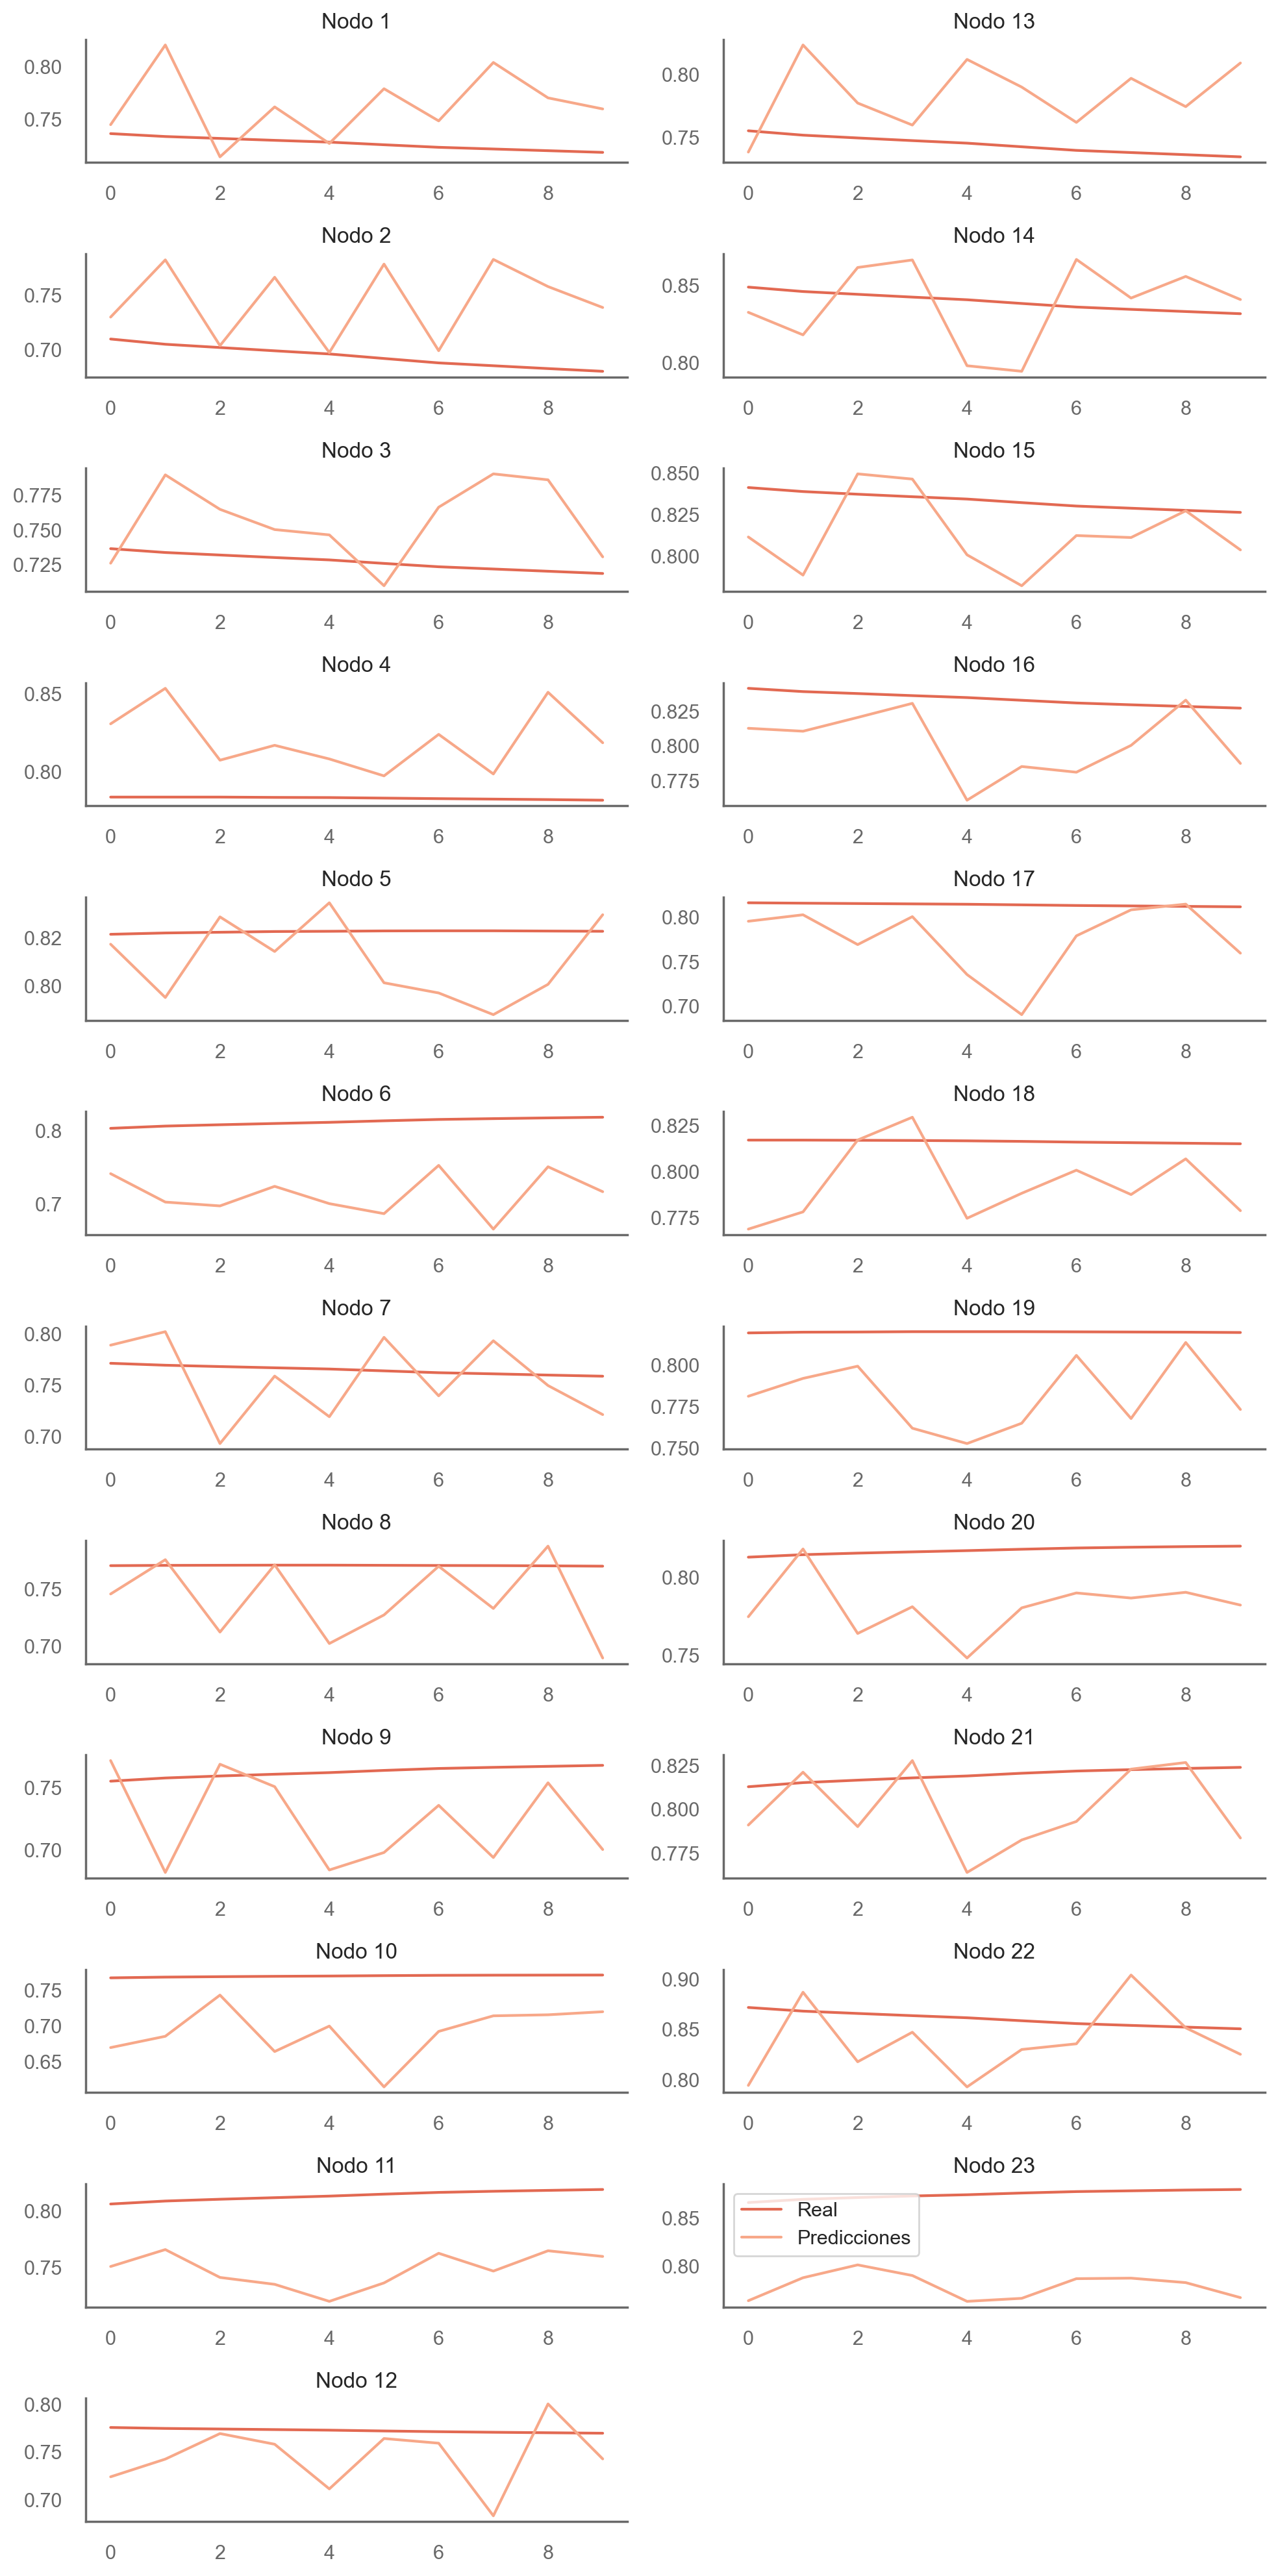

In [238]:
n_situation = 1
predictions_situation = predictions[n_situation].tolist()
real_situation = test_dataset.targets[n_situation].tolist()
n_plots = 23
n_cols = 2
n_rows = (n_plots + 1) // 2  # División redondeada hacia arriba

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 20),dpi=200)
# Trazar los gráficos
for i in range(n_plots):
    row = i % n_rows  # Calculamos el índice de la fila
    col = i // n_rows  # Calculamos el índice de la columna
    ax = axs[row, col] if n_plots > 1 else axs
    
    ax = axs[row, col] if n_plots > 1 else axs
    
    sns.lineplot(y=real_situation[i],x=range(n_target), ax=ax, label='Real', legend=False)
    

    sns.lineplot(y=predictions_situation[i],x=range(n_target),ax=ax, label='Predicciones', legend=False)
    
    ax.set_title(f'Nodo {i+1}')
    format_plot(ax)
    # Añadir leyenda solo al último plot
    if i == n_plots - 1:
        ax.legend(loc='upper left')

if n_plots % n_cols != 0:
    fig.delaxes(axs.flatten()[-1])
# Ajustes finales
plt.tight_layout()
plt.show()